In [1]:
library(tidyverse)
library(ggthemes)

── Attaching packages ────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”
Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘tidyr’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
Warning message:
“package ‘dplyr’ was built under R version 4.1.1”
Warning message:
“package ‘stringr’ was built under R version 4.1.1”
Warning message:
“package ‘forcats’ was built under R version 4.1.1”
── Conflicts ───────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
RSS <- function(yObs, yFit)
{
    # RSS: Compute the residual sums of squares
    # yObs: the observed response y
    # yFit: the fitted response y
    return(sum((yObs - yFit)^2))
}

In [3]:
ASE <- function(yTruth, yFit)
{
    # ASE: Compute the mean average squared error
    # yObs: the observed response y
    # yFit: the fitted response y
    return(mean((yTruth - yFit)^2))
}

In [4]:
library(mgcv) # penalised regression splines
library(MRSea) # SALSA
# Read simulated dataset from Moodle
df <- read.csv("SimulatedData.csv")

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-35. For overview type 'help("mgcv-package")'.


Attaching package: ‘MRSea’


The following object is masked from ‘package:dplyr’:

    contains


The following object is masked from ‘package:tidyr’:

    contains




In [5]:
square_residuals = c()
abs_residuals = c()
fitted = c()
for (i in seq(100))
{
    # Subset dataset
    dfSub <- subset(df, ID %in% i)
    poly_model = lm(response ~ poly(x, degree=6), data=dfSub)
    predictions = predict(poly_model, dfSub, type="response")
    fitted = c(fitted, predictions)
    sq_res = RSS(dfSub$response, predictions)
    abs_res = ASE(dfSub$response, predictions)
    square_residuals = c(square_residuals, sq_res)
    abs_residuals = c(abs_residuals, abs_res)
}

df = df %>% add_column(fitted = fitted)

#### Plot the simulated data, the fitted data and the true underlying function (𝜇) to examine the model fits.

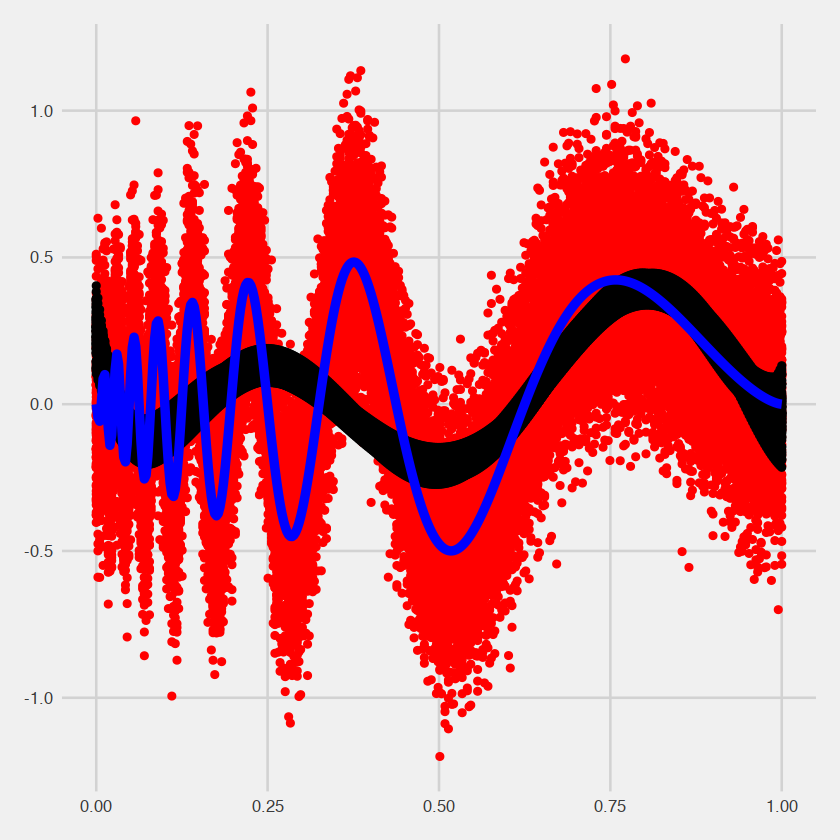

In [6]:
ggplot(data=df) + geom_point(aes(x=x, y=response), colour="red") + 
geom_point(aes(x=x, y=fitted)) + 
geom_line(aes(x=x, y=mu), colour="blue", size=2) + 
theme_fivethirtyeight(base_size = 12, base_family = "sans")

### PRS

In [7]:
library(mgcv)
PRS <- mgcv::gam(response ~ s(x), data=df)

In [8]:
prs_square_residuals = c()
prs_abs_residuals = c()
prs_fitted = c()
for (i in seq(100))
{
    # Subset dataset
    dfSub <- subset(df, ID %in% i)
    PRS <- mgcv::gam(response ~ s(x), data=dfSub)
    predictions = predict(PRS, dfSub, type="response")
    prs_fitted = c(prs_fitted, predictions)
    prs_sq_res = RSS(dfSub$response, predictions)
    prs_abs_res = ASE(dfSub$response, predictions)
    prs_square_residuals = c(prs_square_residuals, prs_sq_res)
    prs_abs_residuals = c(prs_abs_residuals, prs_abs_res)
}
df = df %>% add_column(fittedPRS = prs_fitted)

#### Plot the simulated data, the fitted data and the true underlying function (𝜇) to examine the model fits.

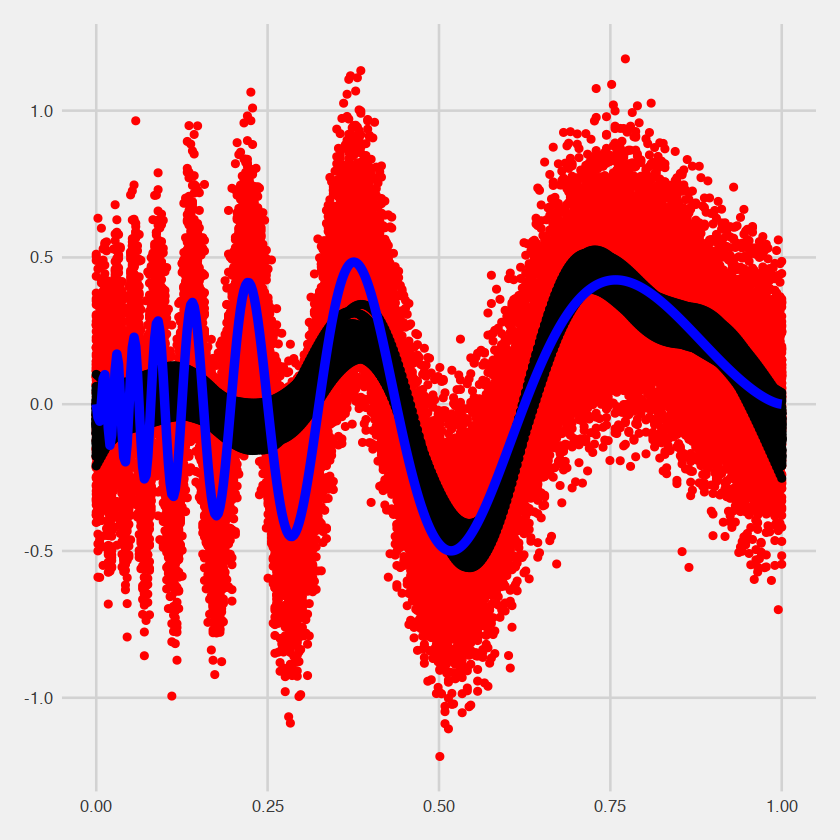

In [9]:
ggplot(data=df) + geom_point(aes(x=x, y=response), colour="red") + 
geom_point(aes(x=x, y=fittedPRS)) + 
geom_line(aes(x=x, y=mu), colour="blue", size=2) + 
theme_fivethirtyeight(base_size = 12, base_family = "sans")

### SALSA

In [10]:
library(MRSea) # SALSA

In [11]:
# Loop across all sets of data
salsa_square_residuals = c()
salsa_abs_residuals = c()
salsa_fitted = c()
knots = c()
for (i in seq(100))
{
    # Subset dataset
    dfSub <- subset(df, ID %in% i)
    # Fit initial NULL model
    initialModel <- glm(response ~ 1, data=dfSub)
    # Set SALSA arguments
    varList <- c("x")
    salsa1DList <- list(fitnessMeasure="BIC",
    minKnots_1d=2, maxKnots_1d=40,
    startKnots_1d=10, degree=2,
    maxIterations=10, gaps=0)
    # Run SALSA
    salsa <- MRSea::runSALSA1D(initialModel=initialModel,
        salsa1dlist=salsa1DList,
        varlist=varList,
        factorlist=NULL,
        datain=dfSub,
        splineParams=NULL,
        suppress.printout=TRUE)
    # Compute and save RSS/ASE and number of knots
    bestModel <- salsa$bestModel
    params <- bestModel$splineParams
    predictions = predict.gamMRSea(newdata = dfSub, object = bestModel)
    knots = c(knots, length(bestModel$splineParams[[2]]$knots))
    salsa_fitted = c(salsa_fitted, predictions)
    salsa_sq_res = RSS(dfSub$response, predictions)
    salsa_abs_res = ASE(dfSub$response, predictions)
    salsa_square_residuals = c(salsa_square_residuals, salsa_sq_res)
    salsa_abs_residuals = c(salsa_abs_residuals, salsa_abs_res)
}

Loading required package: splines

Loading required package: fields

Warning message:
“package ‘fields’ was built under R version 4.1.1”
Loading required package: spam

Warning message:
“package ‘spam’ was built under R version 4.1.1”
Spam version 2.8-0 (2022-01-05) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Warning message:
“package ‘viridis’ was built under R version 4.1.1”
Loading required package: viridisLite


Try help(fields) to get started.



In [12]:
df = df %>% add_column(fittedSALSA = salsa_fitted)

#### Plot the simulated data, the fitted data and the true underlying function (𝜇) to examine the model fits.

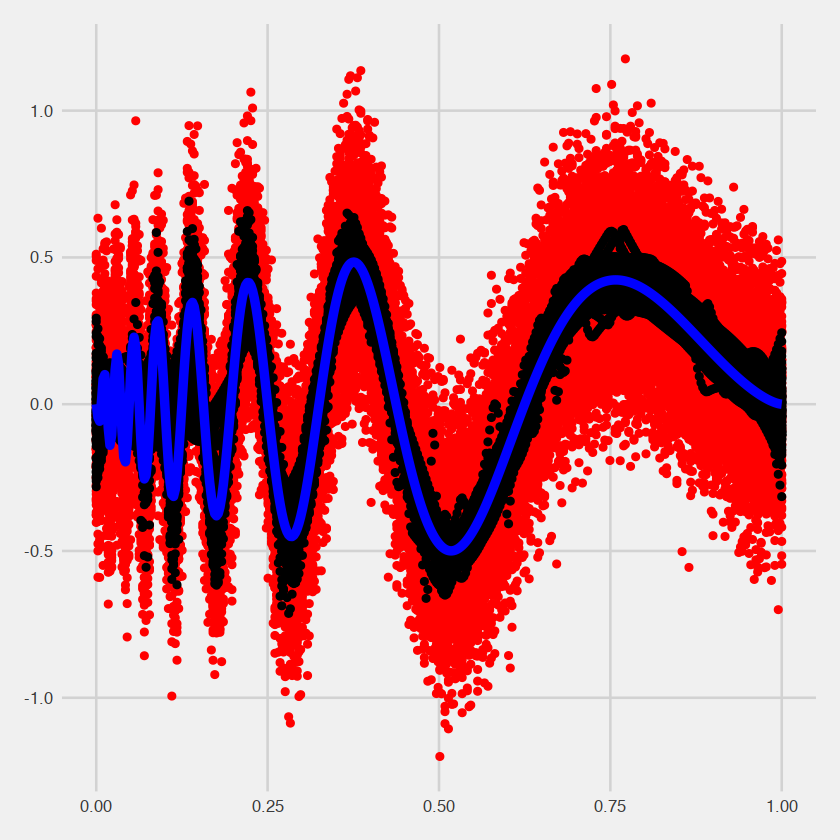

In [13]:
ggplot(data=df) + geom_point(aes(x=x, y=response), colour="red") + 
geom_point(aes(x=x, y=fittedSALSA)) + 
geom_line(aes(x=x, y=mu), colour="blue", size=2) + 
theme_fivethirtyeight(base_size = 12, base_family = "sans")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.00   10.00   11.00   11.09   12.00   14.00 

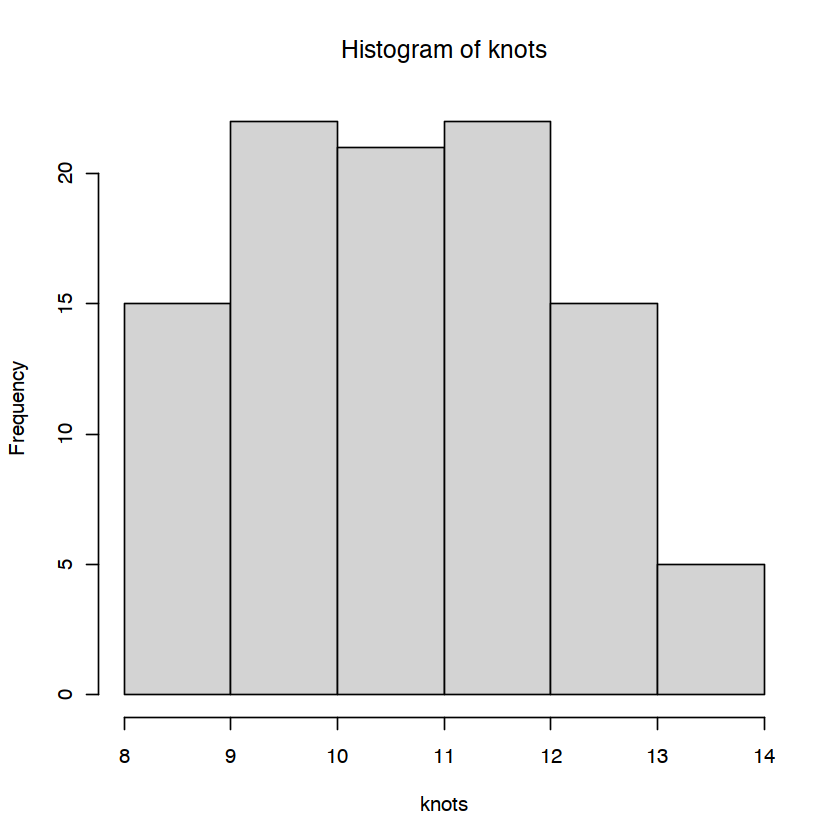

In [14]:
hist(knots)
summary(knots)

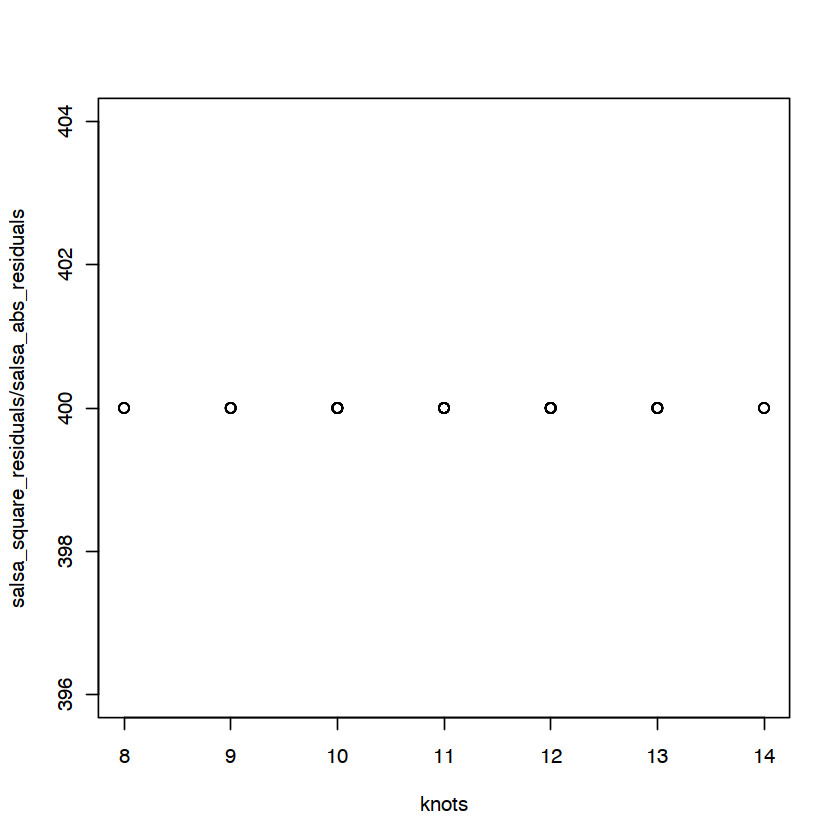

In [15]:
plot(knots, salsa_square_residuals/salsa_abs_residuals)

4. TRUE or FALSE? The mean RSS score for the polynomial curves is about 1.4 (± ∼ 0.4) times the
size of the corresponding value for the PRS-based curves.

In [16]:
mean(square_residuals) / mean(prs_square_residuals)
t.test(square_residuals / prs_square_residuals)

[1] 1.367987


	One Sample t-test

data:  square_residuals/prs_square_residuals
t = 208.89, df = 99, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 1.357026 1.383054
sample estimates:
mean of x 
  1.37004 


5. TRUE or FALSE? The mean ASE score for the polynomial curves is about 1.8 (± ∼ 0.4) times the
size of the corresponding value for the PRS-based curves.

In [17]:
mean(abs_residuals) / mean(prs_abs_residuals)
t.test(abs_residuals / prs_abs_residuals)

[1] 1.367987


	One Sample t-test

data:  abs_residuals/prs_abs_residuals
t = 208.89, df = 99, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 1.357026 1.383054
sample estimates:
mean of x 
  1.37004 


7. TRUE or FALSE? The mean RSS score for the polynomial curves is approximately 2.3 (± ∼ 0.4) times the size of the corresponding value for the spatially adaptive SALSA-based curves.

In [18]:
mean(square_residuals) / mean(salsa_square_residuals)
t.test(square_residuals/salsa_square_residuals)

[1] 2.260074


	One Sample t-test

data:  square_residuals/salsa_square_residuals
t = 125.12, df = 99, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 2.235109 2.307143
sample estimates:
mean of x 
 2.271126 


8. TRUE of FALSE? The mean ASE score for the polynomial curves is approximately 8.6 (± ∼ 0.4) times the size of the corresponding value for the spatially adaptive SALSA-based curves.

In [19]:
mean(abs_residuals) / mean(salsa_abs_residuals)

[1] 2.260074

10. TRUE or FALSE? The mean RSS score for the PRS-based curves is about 1.7 (± ∼ 0.4) times the size of the corresponding value for the spatially adaptive SALSA-based curves.

In [32]:
mean(prs_square_residuals)/mean(salsa_square_residuals)

[1] 1.652117

11.TRUE or FALSE? The mean ASE score for the PRS-based GAMs is about 4.7 (± ∼ 0.4) times the
size of the corresponding value for the spatially adaptive SALSA-based curves.

In [33]:
mean(prs_abs_residuals)/mean(salsa_abs_residuals)

[1] 1.652117

12. TRUE or FALSE? The spatially adaptive SALSA-based GAMs are slower to fit to the data than
PRS-based GAMs but the SALSA-based curves are closer to the underlying function compared to the
PRS-based GAMs (which has a single smoothing parameter for the entire covariate range).

13. As model complexity increases for the SALSA based models, the ASE generally decreases until about 12 knots. Beyond 12 knots the ASE appears to be relatively similar even if the number of knots increases. This is the reason that the ASE is a good fit measure to use in practice when fitting models to observed data.

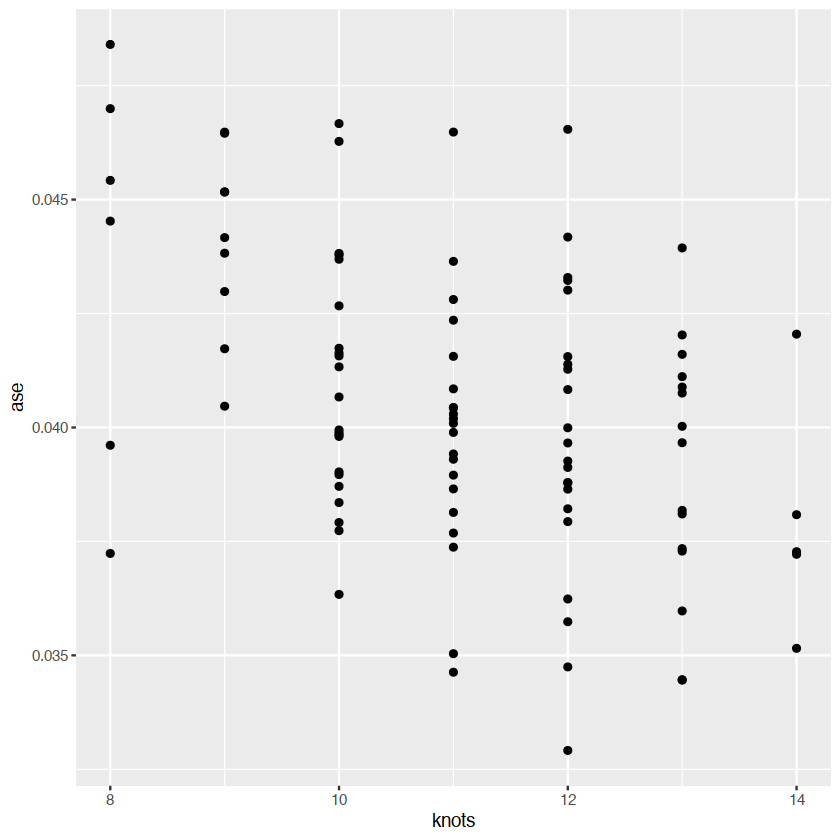

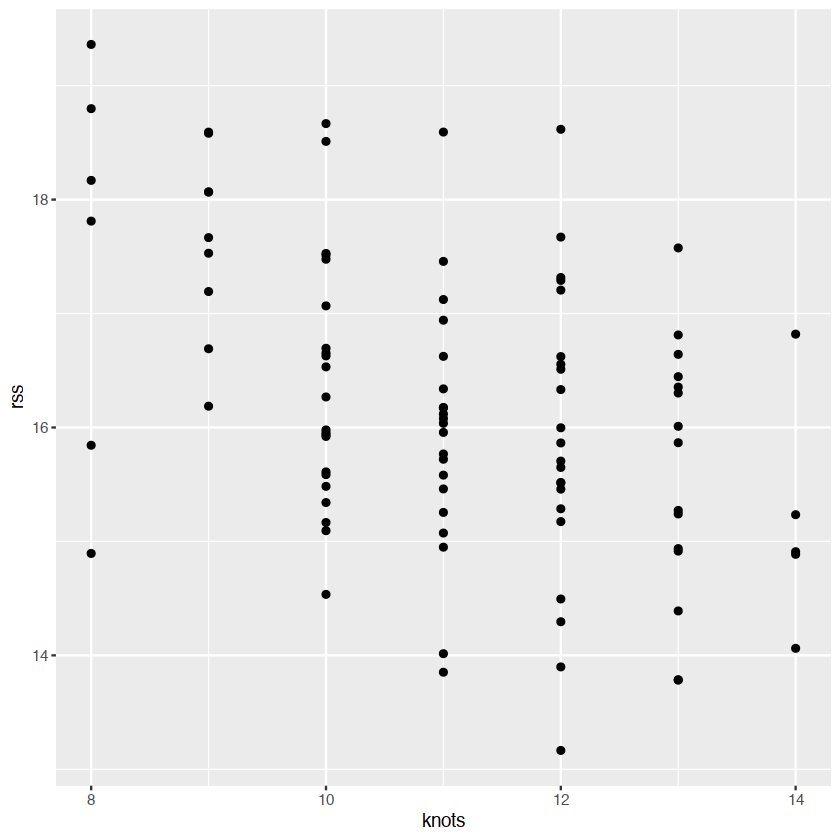

In [47]:
abs_knots = data.frame(ase=salsa_abs_residuals, knots=knots, rss=salsa_square_residuals)
ggplot(aes(knots, ase), data=abs_knots) + geom_point()
ggplot(aes(knots, rss), data=abs_knots) + geom_point()